<a href="https://colab.research.google.com/github/bcoy48/osu-gradtda-5622-sp25/blob/main/course_materials/sync_class/gtda_5622_sp25_modelingAndEvaluation_synch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GRADTDA5622 - Big Data Computing Foundations II  
### **CRISP-DM: Modeling and Evaluation**  
#### Strategic expirimentation and iterating toward resiliency

This notebook will serve as an extension of the asynchronous content about tuning a K-Nearest Neighbors model (KNN) using a pre-defined cost matrix. Here, we will review commonly used classification models which accepts multiple hyperparameters (e.g., Decision Tree, XGBoost) and we will work to define a robust evaluation method (e.g., nested cross validation via grid search [which could be parallelized when needed]). The most important take away of this notebook is not the code itself, but the design of the expiriment. Any predictive model must be rigorously tested to ensure that the model will repeatedly flourish when provided with unseen production data. The model results must also be interpretable by a consumer (machine, statekholder, etc.) to ensure that the model's value is often proven.

Helpful resources:  
* [Decision Trees](https://scikit-learn.org/stable/modules/tree.html)  
* [XGBoost](https://xgboost.readthedocs.io/en/stable/tutorials/model.html)  
* [Cross Validation Methods](https://ieeexplore-ieee-org.proxy.lib.ohio-state.edu/stamp/stamp.jsp?tp=&arnumber=10596885)  
* [Shapley Values](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html)

---  
### Retrieve and preprocess the dataset  
The clean Iris data resulting from the [Data Prep notebook](https://bcoy48.github.io/osu-gradtda-5622-sp25/course_materials/sync_class/gtda_5622_sp25_dataPrep_synch.ipynb) will be used in the following demonstration. As a reminder, the raw data required some minor data quality clean up and then standardizing or encoding of possible features.

In [2]:
import pandas as pd

# Increase the dataframe dispaly width
pd.set_option('display.width', 1000)

# Establish the URL root
str_url = 'https://bcoy48.github.io/osu-gradtda-5622-sp25/course_materials/sync_class/'

# Establish a file name, if not consuming from a production location
str_file = 'teb_enhanced_iris_dataset_v2.xlsx'
str_sheet = 'enhanced1_copy_with_errors'

# Retrieve the data (dynamically)
df_orig = pd.read_excel(str_url + str_file, sheet_name=str_sheet)

# Drop fully duplicative rows
df_orig = df_orig.drop_duplicates()

# Drop the incorrect record for the duplicative row id
df_orig = df_orig[(df_orig.index != 150)]

# Correct all petal area and sepal area values
df_orig['petal_area'] = df_orig.petal_length * df_orig.petal_width
df_orig['sepal_area'] = df_orig.sepal_length * df_orig.sepal_width

# Correct all sepal shape values
df_orig['sepal_shape_val'] = df_orig.sepal_length / df_orig.sepal_width

# Strip extra whitespace from the flower color strings and set to lower case
df_orig['color'] = df_orig.color.str.strip().str.lower()

# Recode the misspelled species string
df_orig.loc[(df_orig.species == 'setos'), 'species'] = 'setosa'

# Print an overview of the dataset
print(f'Raw dataset {df_orig.shape}:\n\n{df_orig.head(10)}')

Raw dataset (150, 14):

   row_id  sepal_length  sepal_width  petal_length  petal_width species  sepal_area  sepal_shape_val sepal_shape  petal_area  petal_shape_val petal_shape     color  zone
0       0           5.1          3.5           1.4          0.2  setosa       17.85         1.457143      square        0.28         7.000000   very_long    violet     6
1       1           4.9          3.0           1.4          0.2  setosa       14.70         1.633333      square        0.28         7.000000   very_long     white     4
2       2           4.7          3.2           1.3          0.2  setosa       15.04         1.468750      square        0.26         6.500000   very_long    violet     5
3       3           4.6          3.1           1.5          0.2  setosa       14.26         1.483871      square        0.30         7.500000   very_long    violet     4
4       4           5.0          3.6           1.4          0.2  setosa       18.00         1.388889      square        0.28  

In [62]:
# Subset the original dataframe to desired columns - DEFINE
df_clean_cols = ['species', 'sepal_shape_val', 'sepal_area', 'petal_area', 'color']

# Subset the original dataframe to desired columns - EXECUTE
df_clean = df_orig.loc[(~df_orig.species.isnull()), df_clean_cols]

# Scale each of the continuous features - ANCHORS
sepal_shape_max = df_clean.sepal_shape_val.max()
sepal_area_max = df_clean.sepal_area.max()
petal_area_max = df_clean.petal_area.max()

# Scale each of the continuous features - EXECUTE
df_clean['sepal_shape_val'] = df_clean.sepal_shape_val / sepal_shape_max
df_clean['sepal_shape_val'] = df_clean.sepal_area / sepal_area_max
df_clean['sepal_shape_val'] = df_clean.petal_area / petal_area_max

# One-hot encode the categorical features
color_dummies = pd.get_dummies(df_clean.color, dtype=float)

# Drop the original categorical feature and append the encoded values
df_clean = pd.concat([df_clean.iloc[:, :-1], color_dummies], axis=1)

# Recode the label values to be numeric - DEFINE
species_dict = {'setosa': 0, 'versicolor': 1, 'virginica': 2}

# Recode the label values to be numeric - EXECUTE
df_clean['species'] = df_clean.species.apply(lambda x: species_dict[x])

# Print an overview of the dataset
print(f'Raw dataset {df_clean.shape}:\n\n{df_clean.head(10)}')

Raw dataset (149, 10):

   species  sepal_shape_val  sepal_area  petal_area  blue  lavender  pink  purple  violet  white
0        0         0.017643       17.85        0.28   0.0       0.0   0.0     0.0     1.0    0.0
1        0         0.017643       14.70        0.28   0.0       0.0   0.0     0.0     0.0    1.0
2        0         0.016383       15.04        0.26   0.0       0.0   0.0     0.0     1.0    0.0
3        0         0.018904       14.26        0.30   0.0       0.0   0.0     0.0     1.0    0.0
4        0         0.017643       18.00        0.28   0.0       0.0   0.0     0.0     1.0    0.0
5        0         0.042848       21.06        0.68   0.0       0.0   0.0     0.0     1.0    0.0
6        0         0.026465       15.64        0.42   0.0       0.0   1.0     0.0     0.0    0.0
7        0         0.018904       17.00        0.30   0.0       0.0   0.0     0.0     0.0    1.0
8        0         0.017643       12.76        0.28   0.0       0.0   0.0     1.0     0.0    0.0
9     

---  
### Establish a baseline classification interpretation  
Using the prepared dataset, we will investigate tree-based decisions to learn a little bit more about the data describing each of the Iris species. See this [link](https://en.wikipedia.org/wiki/Iris_(plant)) for addtional domain knowledge.

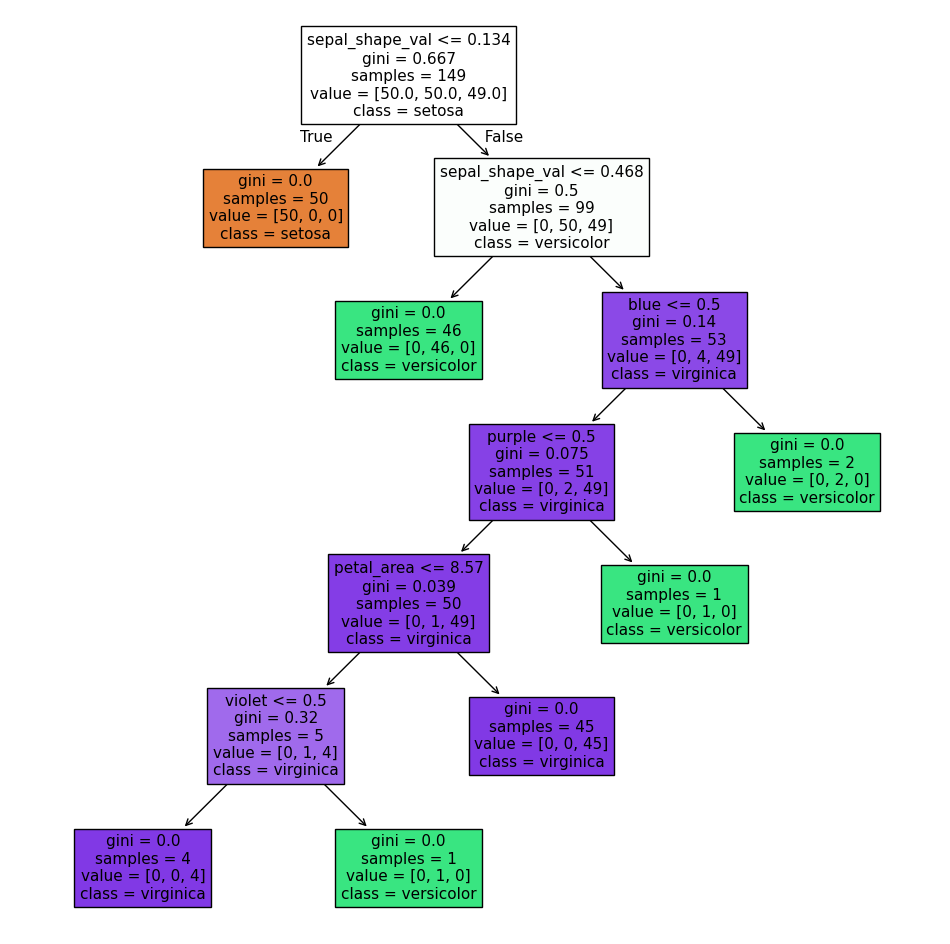

In [63]:
import matplotlib.pyplot as plt
from sklearn import tree

# Separate the label and feature data in full
X = df_clean.iloc[:, 1:]
y = df_clean.iloc[:, 0]

# Instantiate a default decision tree classifier
clf_dt = tree.DecisionTreeClassifier(random_state=42)

# Fit the prepared decision tree classifier
clf_dt = clf_dt.fit(X, y)

# Review the tree-based decisions via the fit model - PREP
feature_names = X.columns
class_names = list(species_dict.keys())

# Review the tree-based decisions via the fit model - EXECUTE
plt.figure(figsize=(12,12))
tree.plot_tree(clf_dt, feature_names=feature_names, class_names=class_names, filled=True, fontsize=11)
plt.show()

**Reference Information**:  
CART takes a feature and determines which cut-off point minimizes the variance of for a regression task or the Gini index of the class distribution of for classification tasks. The variance tells us how much the values in a node are spread around their mean value. The Gini index tells us how “impure” a node is e.g., if all classes have the same frequency, the node is impure; if only one class is present, it is maximally pure. Variance and Gini index are minimized when the data points in the nodes have very similar values for. As a consequence, the best cut-off point makes the two resulting subsets as different as possible with respect to the target outcome. For categorical features, the algorithm tries to create subsets by trying different groupings of categories. After the best cutoff per feature has been determined, the algorithm selects the feature for splitting that would result in the best partition in terms of the variance or Gini index, and adds this split to the tree. The algorithm continues this search-and-split recursively in both new nodes until a stop criterion is reached. Possible criteria are: A minimum number of instances that have to be in a node before the split, or the minimum number of instances that have to be in a terminal node.  
...  
The overall importance of a feature in a decision tree can be computed in the following way: Go through all the splits for which the feature was used and measure how much it has reduced the variance or Gini index compared to the parent node.    

Source: https://christophm.github.io/interpretable-ml-book/tree.html

**Interpretation**:  
The parent decision predicts 'setosa' if the `sepal_shape_val` is <= 0.134. This decision lables approximately one third of the data. Then, the majority of 'versicolor' predictions are labeled if the `sepal_shape_val` is <= 0.468. A few of the 'versicolor' predictions occur based on the flower's color, but nearly all of the remaining observations are labeled 'virginica'. This approach prefectly predicts the actual results (see below), but let's recognize that this step should be considered an illustration of one additional method for learning about the utility of your data preparation approach.

In [64]:
from sklearn.metrics import confusion_matrix

# Intending to put the decision tree results into context: review the trained model's accuracy
confusion_matrix(y, clf_dt.predict(X))

array([[50,  0,  0],
       [ 0, 50,  0],
       [ 0,  0, 49]])

---  
### Illustrate a production-grade modeling approach  
The subsequent steps intend to demonstrate a commonly used approach for developing a resilient classification model without overfitting. The crucial steps include:  
>1) Establish a cost function to evaluate the model's efficacy to represent the domain context.  
>2) Shuffle rows and use a stratified splitting techniques to establish training and testing (i.e., out of sample) data.  
>3) Establish a nested cross-validation training method.  
>4) Use a grid search technique to evaulate hyperparameter settings in training.  
>5) Test the best performing model with out of sample data and evaluate the consistency of the chosen model's performance.  
>6) Evaluate feature importance and individual prediction explanations (randomly selected) based on domain knowledge.

**Replicate Dr. Bihari's cost function**  
We'll use numpy matrix operations to streamline the cost assessment.

In [88]:
import numpy as np

# ** Demonstrate the meaning of the cost matrix **
"""
        PREDICTED VALUES
    setosa  versicolor   virginica
 [    400       -200       -300] setosa
 [   -100        800       -300] versicolor  TRUE VALUES
 [   -100       -200       1200] virginica
"""

# Establish the cost matrix object
iris_cost_matrix = np.array([[400,-200,-300], [-100,800,-300], [-100,-200,1200]])

print('Established cost matrix.')

Established cost matrix.


**Establish train and test datasets**  
It's important to stratify the split across the label's classes (e.g., `species`).

In [66]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold

# Instantiate a base splitting method
base_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=True)

# Establish the first round of splits
base_assignments = [(train, holdout) for i, (train, holdout) in enumerate(base_splitter.split(X, y))]

# Store the holdout set separate from the remainder
X_train = X.iloc[base_assignments[0][0]]
y_train = y.iloc[base_assignments[0][0]]
X_holdout = X.iloc[base_assignments[0][1]]
y_holdout = y.iloc[base_assignments[0][1]]

# Instantiate the stratified splitting method
fold_splitter = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Establish an object to capture the split assignments
fold_assignments = [(i, train, test) for i, (train, test) in enumerate(fold_splitter.split(X_train, y_train))]

print(f'Established {len(fold_assignments)} training folds and 1 holdout set.')

Established 3 training folds and 1 holdout set.


In [68]:
# Review the distribution of labels in one of the training folds
y_train.iloc[fold_assignments[0][1]].value_counts()

,count
species,
0,25
1,25
2,24


**Define a method to train and assess a XGBoost model**  
Deliberately verbose assessment of various hyperparameter settings, seeking performance consistency across folds.

In [142]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix

# Establish a function to test various hyperparameter settings
def XGBParamTuning(params, cost_matrix=iris_cost_matrix):

  # Instantiate a sample classifier model
  bst = XGBClassifier(n_estimators=params[0], max_depth=params[1], learning_rate=params[2], objective=params[3], num_class=3)

  # Establish a function to simplify the looping over folds
  def XGBFoldAssessment(fold_id, cost_matrix=cost_matrix):

    # Fit model
    bst.fit(X_train.iloc[fold_assignments[fold_id][1]], y_train.iloc[fold_assignments[fold_id][1]])

    # Make predictions
    y_preds = bst.predict(X_train.iloc[fold_assignments[fold_id][2]])

    # Assess the predictions
    possible_cost = np.multiply(cost_matrix, confusion_matrix(y_train.iloc[fold_assignments[fold_id][2]], y_train.iloc[fold_assignments[fold_id][2]])).sum()
    predicted_cost = np.multiply(cost_matrix, confusion_matrix(y_train.iloc[fold_assignments[fold_id][2]], y_preds)).sum()

    # Return the assessment
    return  possible_cost / predicted_cost

  # Assess the consistency of the value of each fold
  fold_assessment = [XGBFoldAssessment(f) for f in [0,1,2]]

  # Review the difference between the min and max values
  fold_range = max(fold_assessment) - min(fold_assessment)

  # Return the settings and cost range
  return (params, fold_range, sum(fold_assessment) / len(fold_assessment))

print('Established hyperparameter tuning function.')

Established hyperparameter tuning function.


In [143]:
# Establish an empty list to write model iterations to
XGBTrainingResults = []

# Establish a nested set of possible hyperparameters
for obj in ['multi:softmax', 'multi:softprob']:
  for lr in [0.1, 0.25, 0.5, 0.75, 0.9]:
    for md in [2, 4, 6, 8, 10]:
      for est in [1, 2, 3, 4, 5]:

        # Test the function
        XGBTrainingResults.append(XGBParamTuning((est, md, lr, obj)))

print(f'Tuned training complete for {len(XGBTrainingResults)} options.')

Tuned training complete for 250 options.


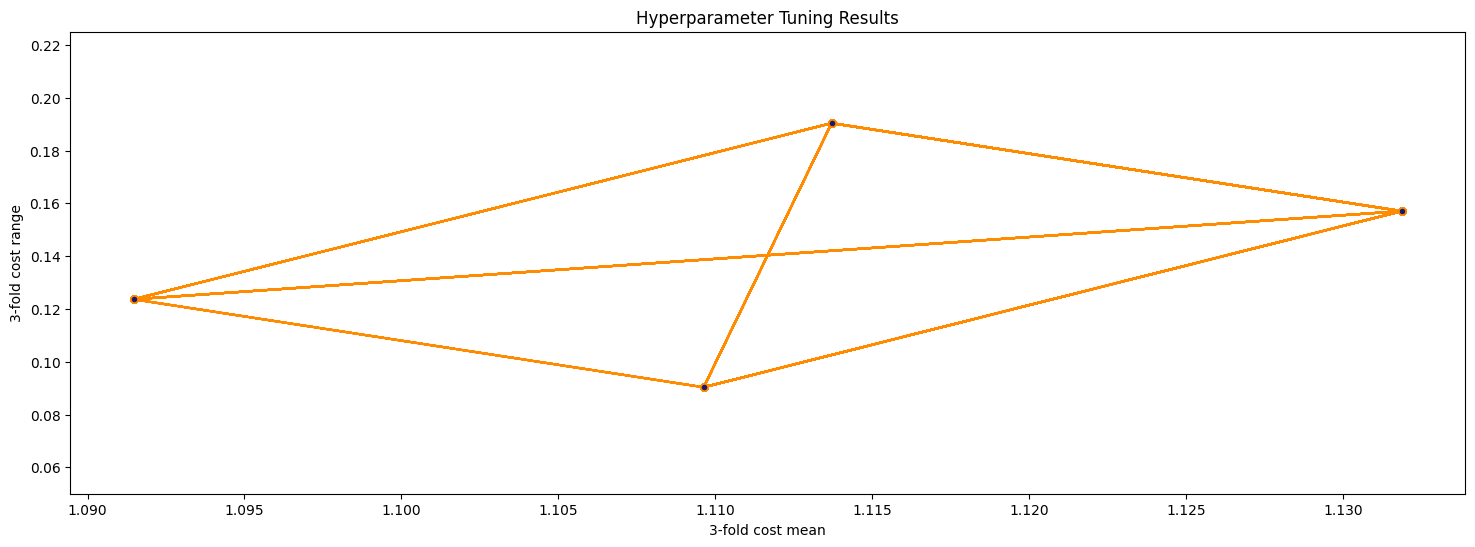

In [144]:
# Visualize the training results
plt.figure(figsize=(18, 6))
plt.plot(list(map(lambda x: x[2], XGBTrainingResults)), list(map(lambda x: x[1], XGBTrainingResults)), color='darkorange', linestyle='dashed', marker='o', markerfacecolor='midnightblue', markersize=5)
plt.ylim(0.05, 0.225)
plt.xlabel('3-fold cost mean')
plt.ylabel('3-fold cost range')
plt.title('Hyperparameter Tuning Results')
plt.show()

**Interpretation**:  
Even though 250 different possible combinations of hyperparameters were tested, we observe four common outcomes. The left-most point (approximate mean of 1.09 and approximate range of 0.124) produces the lowest relative close (best possible cost = 1.0). The lower, middle point (approximate mean of 1.1 and approximate range of 0.09) produces the most consistent performance across all three folds. Since the original goal of our assessment is consistency, we will select the simplest model settings from all of the options at the lower, middle point. These settings will be used to evaluate the hold out dataset.

---  
### Evaluate the selected model  
We will review the performance on the hold out dataset and, as before, we'll investigate variable importance and randomly selected prediction explanations to see if the results fit our domain knowledge.

**Hold out performance**  
We will review the full classification report in addition to the confusion matrix and cost assessment.

In [177]:
from sklearn.metrics import classification_report

# Establish the simplest settings of the chosen results
chosen_settings = (4, 4, 0.25, 'multi:softmax')

# Instantiate a final classifier model (typically, the best model is saved during tuning)
bst = XGBClassifier(n_estimators=chosen_settings[0], max_depth=chosen_settings[1], learning_rate=chosen_settings[2], objective=chosen_settings[3], num_class=3)

# Fit the model on the full training dataset
bst.fit(X_train, y_train)

# Make predictions on the original holdout set
y_preds = bst.predict(X_holdout)

# Assess the hold out predictions - COST
possible_cost = np.multiply(iris_cost_matrix, confusion_matrix(y_holdout, y_holdout)).sum()
predicted_cost = np.multiply(iris_cost_matrix, confusion_matrix(y_holdout, y_preds)).sum()

# Assess the hold out predictions - CLASSIFICATION REPORT
print(classification_report(y_holdout, y_preds, target_names=['setosa', 'versicolor', 'virginica']))
print(f'Confusion matrix:\n{confusion_matrix(y_holdout, y_preds)}\n')
print(f'A predicted cost of {predicted_cost} against a possible cost of {possible_cost}.')

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        13
  versicolor       1.00      0.92      0.96        13
   virginica       0.92      1.00      0.96        12

    accuracy                           0.97        38
   macro avg       0.97      0.97      0.97        38
weighted avg       0.98      0.97      0.97        38

Confusion matrix:
[[13  0  0]
 [ 0 12  1]
 [ 0  0 12]]

A predicted cost of 28900 against a possible cost of 30000.


**Fit model's feature importance**  
Notice that the model is only using the `sepal_shape_val`, which was the most main parent tree in the decision tree model above.

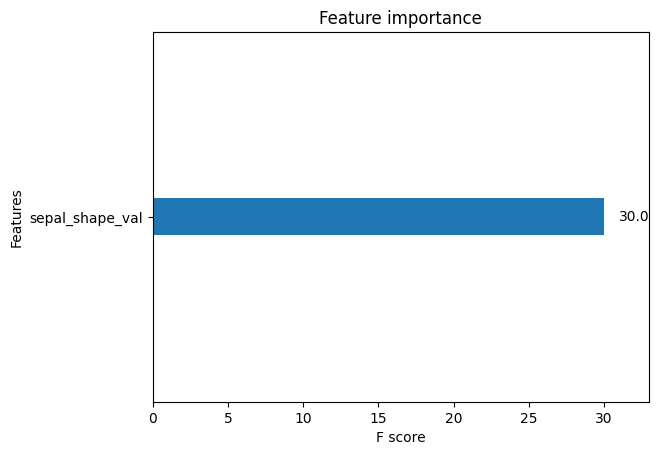

In [241]:
from xgboost import plot_importance

# Plot the fit model's feature importance
plot_importance(bst,  max_num_features=X_holdout.shape[1], grid=False)
plt.show()

**Individual prediction's reason (e.g., SHAP values)**  
Again, we see that the `sepal_shape_val` is the most important feature.

Row ID: 6

Predicted value: versicolor
Actual value: versicolor



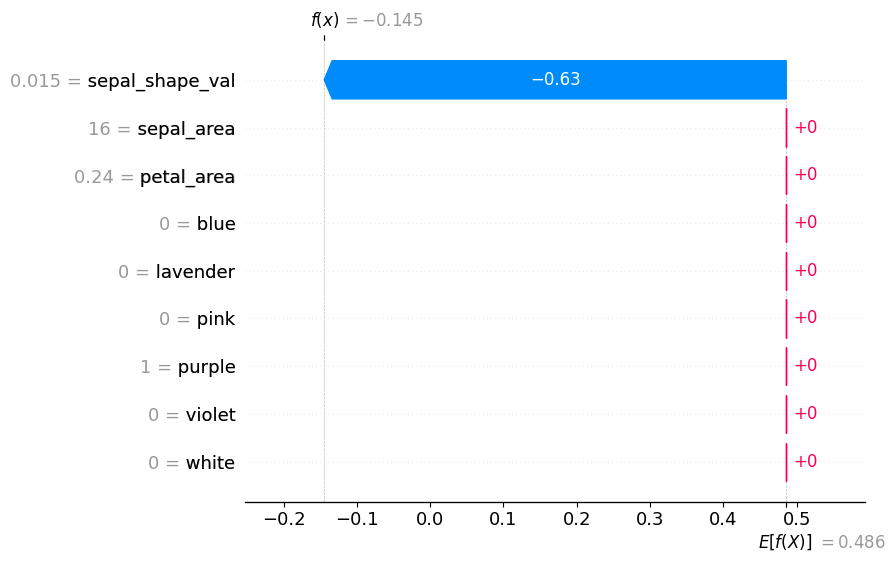

In [240]:
import shap
import random

# Instantiate the Shapley Explainer method
explainer = shap.Explainer(bst)

# Fit the explainer
sv = explainer(X_train)

# Store the Explanation features
exp = shap.Explanation(sv[:,:,2], sv.base_values[:,2], X_holdout, feature_names=X_holdout.columns)

# Visualize the result for a single, chosen prediction
idx = random.choice(range(len(y_preds)))
print(f"Row ID: {idx}\n\nPredicted value: {['setosa', 'versicolor', 'virginica'][y_preds[idx]]}\nActual value: {['setosa', 'versicolor', 'virginica'][y_holdout.iloc[idx]]}\n")
shap.waterfall_plot(exp[idx])